In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

In [30]:
# Function to infer naming conventions for left and right eyes
def infer_naming_conventions(directory):
    left_files = glob(os.path.join(directory, "left", "*.bmp"))
    right_files = glob(os.path.join(directory, "right", "*.bmp"))

    left_pattern = os.path.basename(left_files[0]).replace("1.bmp", "{}.bmp")
    right_pattern = os.path.basename(right_files[0]).replace("1.bmp", "{}.bmp")

    return left_pattern, right_pattern

# Function to load images from a given directory with inferred naming pattern
def load_images(directory, left_pattern, right_pattern, num_images):
    left_images = []
    right_images = []

    for i in range(1, num_images + 1):
        left_path = glob(os.path.join(directory, "left", left_pattern.format(i)))[0]
        right_path = glob(os.path.join(directory, "right", right_pattern.format(i)))[0]

        left_img = load_img(left_path, target_size=(128, 128))
        right_img = load_img(right_path, target_size=(128, 128))

        left_img_array = img_to_array(left_img)
        right_img_array = img_to_array(right_img)

        left_images.append(left_img_array)
        right_images.append(right_img_array)

    return np.array(left_images), np.array(right_images)

# Assuming you have 46 persons, repeat the process for each person and concatenate the data
all_left_images = []
all_right_images = []
labels = []

for person_id in range(1, 46):  # Assuming 46 persons
    person_directory = os.path.join("MMU-Iris-Database", str(person_id))

    left_pattern, right_pattern = infer_naming_conventions(person_directory)

    left_eye_images, right_eye_images = load_images(
        person_directory,
        left_pattern=left_pattern,
        right_pattern=right_pattern,
        num_images=5
    )

    # Create labels (person IDs)
    person_labels = np.full((10,), person_id - 1)  # Adjust index to start from 0

    all_left_images.append(left_eye_images)
    all_right_images.append(right_eye_images)
    labels.append(person_labels)

# Concatenate data for all persons
all_left_images = np.concatenate(all_left_images)
all_right_images = np.concatenate(all_right_images)
labels = np.concatenate(labels)

# Combine left and right eye images
all_images = np.concatenate([all_left_images, all_right_images], axis=0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_images, labels, test_size=0.2, random_state=42)


In [36]:
# Define the CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(45, activation='softmax'))  # Assuming 46 persons

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
12/12 [==============================] - 7s 531ms/step - loss: 86.4973 - accuracy: 0.0250 - val_loss: 3.7746 - val_accuracy: 0.0889
Epoch 2/20
12/12 [==============================] - 6s 488ms/step - loss: 3.6952 - accuracy: 0.0972 - val_loss: 3.7822 - val_accuracy: 0.0778
Epoch 3/20
12/12 [==============================] - 5s 460ms/step - loss: 3.1645 - accuracy: 0.2222 - val_loss: 3.6012 - val_accuracy: 0.1000
Epoch 4/20
12/12 [==============================] - 6s 460ms/step - loss: 2.5082 - accuracy: 0.3389 - val_loss: 3.9124 - val_accuracy: 0.1444
Epoch 5/20
12/12 [==============================] - 6s 478ms/step - loss: 1.5918 - accuracy: 0.5583 - val_loss: 3.9783 - val_accuracy: 0.2222
Epoch 6/20
12/12 [==============================] - 6s 489ms/step - loss: 0.9818 - accuracy: 0.7278 - val_loss: 4.5711 - val_accuracy: 0.2333
Epoch 7/20
12/12 [==============================] - 6s 498ms/step - loss: 0.7025 - accuracy: 0.8139 - val_loss: 4.8557 - val_accuracy: 0.2667
Epoch

In [25]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Assuming you already have your trained model 'model' and test sets 'X_test' and 'y_test'

# Predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Classification Report
class_report = classification_report(y_test, y_pred_classes)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_classes)

# Print results
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)
print("\nAccuracy:", accuracy)

3/3 [==============================] - 0s 84ms/step
Confusion Matrix:
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 6]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         2
           3       1.00      0.67      0.80         3
           4       1.00      0.50      0.67         2
           5       0.75      1.00      0.86         3
           6       0.00      0.00      0.00         0
           7       1.00      0.12      0.22         8
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         2
          10       0.17      1.00      0.29         1
          11       0.40      0.67      0.50         3
          12       0.50      1.00      0.67         1
          13       0.75      

C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\App

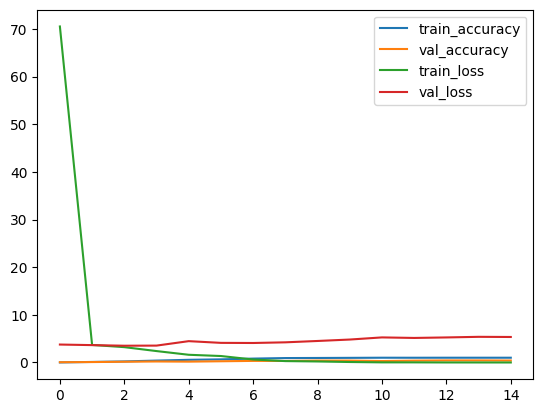

In [8]:
# Plot learning curves
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()